In [1]:
import subprocess
import tensorflow as tf
from tensorflow import summary
import os
import shutil
import json
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import mysql.connector as mysqlpy

# Entrainement du model

## Génération des fichiers spacy à partir des fichiers JSON

In [20]:
!python scripts/convert.py fr assets/train.json corpus/train.spacy
!python scripts/convert.py fr assets/dev.json corpus/dev.spacy
!python scripts/convert.py fr assets/test.json corpus/test.spacy

[07/04/1987, Colite éosinophilique, colite éosinophilique, rue Céline Guérin, 76984 Sainte Susan-les-Bains, Dr Paul Pinto, Antoine Mace]
[11/03/1984, Pityriasis rosé de Gibert, Pityriasis rosé de Gibert, Pityriasis rosé de Gibert, 40, rue de Neveu, 90906 Charpentier-sur-Mer, Dr Alix Da Silva, Guillaume Moreno]
[25/09/1951, colite post-infectieuse, colite post-infectieuse, 23, rue de Pineau, 24163 Sainte Adélaïdeboeuf, Dr Édouard Ledoux, Océane Vaillant, Océane Vaillant, Océane Vaillant]
[22/09/2001, Dermatite péri-orale, dermatite péri-orale, 967, boulevard de Gay, 80997 Mendès, Dr Christelle Vincent, Tristan Le Gall]
[25/09/1951, Dermatite de stase, dermatite de stase, 23, rue de Pineau, 24163 Sainte Adélaïdeboeuf, Dr Alix Da Silva, Océane Vaillant]
[19/06/1948, colite indéterminée, colite indéterminée, 611, boulevard Rey, 65501 Saint Anneville, Dr Denis Duhamel, Guillaume Samson]
[27/11/1961, syndrome de polypose juvénile, syndrome de polypose juvénile, 44, rue Margaud Teixeira, 8337


Map: 100%|██████████| 690/690 [00:00<00:00, 1293.03 examples/s]

Map: 100%|██████████| 690/690 [00:00<00:00, 1416.74 examples/s]


[08/12/1978, lymphome cutané, lymphome cutané, 59, rue Bernadette Sanchez, 92287 Saint Chantal, Dr Antoine Jacquet, Luc Didier]
[09/02/1968, pityriasis rubra pilaire, pityriasis rubra pilaire, 637, avenue Théophile Pelletier, 24660 Sainte Alfred, Dr Olivier Bernier, Adrien Pages]
[05/11/1962, Cancer du côlon métastatique, cancer du côlon métastatique, 249, rue Lambert, 35917 Rogerboeuf, Dr Stéphanie Dupont, Aurélie Launay, Aurélie Launay]
[27/11/1961, 27/11/1961, Carcinome sébacé, carcinome sébacé, 44, rue Margaud Teixeira, 83373 Chevalliernec, 44, rue Margaud Teixeira, 83373 Chevalliernec, Dr Sylvie Nicolas, Alice Guilbert, Alice Guilbert]
[21/08/1981, Dermatite herpétiforme, dermatite herpétiforme, Chemin de Hamon, 17268 LecomteVille, Dr Denis Duhamel, Océane Perrot]
[18/06/1974, dermatite péri-orale, dermatite péri-orale, dermatite péri-orale, 7, Rue Bertrand Rocher, 39507 Jean, Dr Thierry Foucher, Thomas Gérard, Thomas Gérard, Thomas Gérard]
[07/04/1987, Dermatite herpétiforme, der

c:\PCO\generate_model\scripts\convert.py:29: UserWarning: Entité ignorée [1260, 1284, DIAG] dans le texte suivant car l'étendue des caractères 'cancer du côlon mucineux' ne s'aligne pas sur les limites des jetons:

"Compte Rendu d'Histopathologie - Colectomie de Côlon Mucineux Nom de l'anatomopathologiste : Dr Claire Joubert Nom du patient : Édith Blot Date de naissance : 13/02/1967 Adresse du patient : 119, chemin de Normand, 38663 Clerc Numéro de sécurité sociale : 2 1967 02 38663 418 43 Introduction : Le présent compte rendu décrit les résultats de la biopsie réalisée sur le côlon droit d'Édith Blot, âgée de 53 ans, suite à une symptomatologie persistante de douleurs abdominales depuis plusieurs mois. La biopsie a révélé une tumeur maligne dans le côlon mucineux. Matériel et méthodes : La biopsie a été réalisée sous anesthésie locale au niveau de la jonction entre le rectum et le côlon ascendant. Une fine aiguille a été introduite dans la muqueuse du côlon jusqu'à atteindre la zone 

[28/06/1970, 28/06/1970, cystadénome, cystadénome, avenue de Torres, 57536 Peltier, Dr Alfred Fournier, Luce Jacquot, Luce Jacquot, Luce Jacquot]
[08/07/1938, Hémangiome, 52, rue de Merle, 81705 Bouvier, Dr Valentine Bousquet, Dominique Étienne]
[09/01/1986, adénome, Adénome, adénome, 54, rue de Lefort, 54886 Masse, Dr Valentine Bousquet, Roland Jourdan]
[04/03/1985, kyste hépathique, Kyste hépathique, kyste hépathique, 65, boulevard de Lacroix, 17608 Saint Pierredan, Dr Antoine Descamps, Joseph Mahe]
[25/03/1980, carcinome sarcomatoïde, carcinome sarcomatoïde, 1, chemin de Gérard, 90963 Maillot, Dr Agnès Marie, Nicolas Blot]
[16/09/1997, cholangiocarcinome, Cholangiocarcinome, 291, avenue Édouard Robin, 04667 DumontVille, Dr Véronique Lambert, Daniel Millet, Daniel Millet]
[04/01/1979, carcinome fibrolamellaire, 67, chemin de Bernier, 65253 Saint Eugènenec, Dr Alain Masse, Alfred Regnier, Alfred Regnier]
[01/03/1951, cancer des canaux biliaires intrahépatiques, 859, rue Honoré Wagner,


Map: 100%|██████████| 15/15 [00:00<00:00, 833.11 examples/s]

Map: 100%|██████████| 15/15 [00:00<00:00, 999.31 examples/s]


In [2]:
def renommer_dossier(nom_dossier_a_modifier, dossier_ref):  
    try:        
        nb_dans_dossier_ref = len(os.listdir(dossier_ref))
        nouveau_nom_dossier = f'{nom_dossier_a_modifier}_{nb_dans_dossier_ref + 1}' 
        os.rename(nom_dossier_a_modifier, nouveau_nom_dossier)
        
        print(f"Dossier '{nom_dossier_a_modifier}' a été renommé en '{nouveau_nom_dossier}' avec succès.")

        return nouveau_nom_dossier
    except Exception as e:
        print(f"Une erreur s'est produite lors du renommage du dossier : {e}")

def deplacer_dossier(source, destination):    
    try:
        source_nom_modifie = renommer_dossier(source, destination)
        print('source nom modifie', source_nom_modifie)
        shutil.move(source_nom_modifie, destination)
        print(f"Dossier déplacé de '{source}' vers '{destination}' avec succès.")
    except Exception as e:
        print(f"Une erreur s'est produite lors du déplacement du dossier : {e}")

def tensorboard_log(dossier_parent):
    try:
        dossiers = os.listdir(dossier_parent)
        num_dossier = len(dossiers) + 1
        dossier_log = dossier_parent + '/essai_' + str(num_dossier)
        print(f"Dossier essai_{num_dossier} a été créé avec succès.")
        os.mkdir(dossier_log)
        return dossier_log
    except Exception as e:
        print(f"Une erreur s'est produite lors de la création du dossier : {e}")

def write_log_tensorboard(etap, score, ents_r, ents_p, ents_f, loss_ner, loss_tok2vec):
    tf.summary.scalar('SCORE', float(score), step=int(etap))
    tf.summary.scalar('ENTS_R (rappel)', float(ents_r), step=int(etap))
    tf.summary.scalar('ENTS_P (précision)', float(ents_p), step=int(etap))
    tf.summary.scalar('ENTS_F (score f1)', float(ents_f), step=int(etap))
    tf.summary.scalar('LOSS_NER', float(loss_ner), step=int(etap))
    tf.summary.scalar('LOSS_TOK2VEC', float(loss_tok2vec), step=int(etap))
    

## Entrainement et validation

Pour lancer directement tensorboard dans VSC, appuyer sur les touches "Ctrl + Shift + P" puis choisir "lancer TensorBoard", un nouvel onglet s'ouvre.

In [21]:
source = r'C:\PCO\generate_model\training'
destination = r'C:\PCO\generate_model\versioning'

# déplace le dossier training précédent dans le dossier training_save, car il doit être effacé pour relancer le modèle.
deplacer_dossier(source, destination)

# création d'un nouveau dossier à chaque fois qu'un nouveau modèle est lancé pour stocker le fichier pour tensorboard
# nécessaire pour lire chaque essai individuellement (autrement ils sont fusionnés !)
dossier_parent = r"C:\PCO\generate_model\log_tensorboard"
dossier_log = tensorboard_log(dossier_parent)

# Créer un objet SummaryWriter pour écrire les fichiers de journal
writer = summary.create_file_writer(dossier_log)

# Récupère les données générées par la commande !spacy project run train
process = subprocess.Popen(["spacy", "project", "run", "train"], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True, encoding='utf-8')
# version jupyter VM
# process = subprocess.Popen(["python", "-m", "spacy", "train", "configs/config.cfg", "--output", "./training", "--paths.train", "./corpus/train.spacy", "--paths.dev", "./corpus/dev.spacy"], 
#                            stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True, encoding='utf-8')
for line in process.stdout:
    line = line.rstrip()
    print(line)
    with writer.as_default():         
         epoch = line[0 : 3].strip()         
         if line[0 : 3].strip().isdigit():
            etap = line[6: 11].strip()
            # récupération des différentes métriques au fur et à mesure qu'elles sont générées.
            score = line[-4: -1].strip()
            ents_r = line[-14: -8].strip()
            ents_p = line[-22:-16].strip()
            ents_f = line[-30:-24].strip()
            loss_ner = line[-38:-32].strip()
            loss_tok2vec = line[-49: -42].strip()
            # print('score', score, ',ents_r', ents_r, ',ents_p', ents_p, ',ents_f', ents_f, ',loss_ner', loss_ner, ',loss_tok2vec', loss_tok2vec)
            # introduction des métriques dans le fichier lu par tensorboard en fonction de l'etap.   
            write_log_tensorboard(etap, score, ents_r, ents_p, ents_f, loss_ner, loss_tok2vec)         
     
# Fermez le processus
process.communicate()
writer.close()

Dossier 'C:\PCO\generate_model\training' a été renommé en 'C:\PCO\generate_model\training_1' avec succès.
source nom modifie C:\PCO\generate_model\training_1
Dossier déplacé de 'C:\PCO\generate_model\training' vers 'C:\PCO\generate_model\versioning' avec succès.
Dossier essai_1 a été créé avec succès.

=================================== train ===================================
Running command: 'C:\PCO\.venv\Scripts\python.exe' -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id -1
ℹ Saving to output directory: training
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE
---  ------  ------------  ---

## Evaluation du modèle.

In [17]:
def lecture_fichier_json(nom_fichier:str):
    try:
        with open(nom_fichier, 'r') as fichier:
            json_file = json.load(fichier)
            return json_file
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier JSON : {e}")
        return None

def ajout_metrics_df(df, metrics:dict):
    df.loc[len(df)] = metrics
    return df    

In [22]:
!spacy project run evaluate


================================== evaluate ==================================
Running command: 'C:\PCO\.venv\Scripts\python.exe' -m spacy evaluate training/model-best corpus/test.spacy --output training/metrics.json
ℹ Using CPU


Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\PCO\.venv\lib\site-packages\spacy\__main__.py", line 4, in <module>
    setup_cli()
  File "C:\PCO\.venv\lib\site-packages\spacy\cli\_util.py", line 87, in setup_cli
    command(prog_name=COMMAND)
  File "C:\PCO\.venv\lib\site-packages\click\core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "C:\PCO\.venv\lib\site-packages\typer\core.py", line 778, in main
    return _main(
  File "C:\PCO\.venv\lib\site-packages\typer\core.py", line 216, in _main
    rv = self.invoke(ctx)
  File "C:\PCO\.venv\lib\site-packages\click\core.py", line 1688, in invoke
    

In [ ]:
def insert_into(essai, taille_train, taille_valid, remarque, hyperparamètre, 
                ents_precision, ents_rappel, ents_scoref1,
                DIAG_precision, DIAG_rappel, DIAG_scoref1,
                PER_precision, PER_rappel, PER_scoref1,
                LOC_precision, LOC_rappel, LOC_scoref1,
                DATE_precision, DATE_rappel, DATE_scoref1):
    user = 'root'
    password = 'example'
    host = 'localhost'
    port = '3307'
    database = 'PCO'
    bdd = mysqlpy.connect(user=user, password=password, host=host, port=port, database=database)

    cursor = bdd.cursor()
    cursor.execute(f'''INSERT INTO metrics (
                   essai, taille_train, taille_valid, remarque, hyperparamètre, 
                   ents_precision, ents_rappel, ents_scoref1,
                   DIAG_precision, DIAG_rappel, DIAG_scoref1,
                   PER_precision, PER_rappel, PER_scoref1,
                   LOC_precision, LOC_rappel, LOC_scoref1,
                   DATE_precision, DATE_rappel, DATE_scoref1)
                   VALUES("{essai}", "{taille_train}", "{taille_valid}", "{remarque}", "{hyperparamètre}", 
                   "{ents_precision}", "{ents_rappel}", "{ents_scoref1}",
                   "{DIAG_precision}", "{DIAG_rappel}", "{DIAG_scoref1}",
                   "{PER_precision}", "{PER_rappel}", "{PER_scoref1}",
                   "{LOC_precision}", "{LOC_rappel}", "{LOC_scoref1}",
                   "{DATE_precision}", "{DATE_rappel}", "{DATE_scoref1}");''')
    bdd.commit()
    cursor.close()
    bdd.close()


In [ ]:
json_metric = r'C:\PCO\generate_model\training\metrics.json'
metrics = lecture_fichier_json(json_metric)

with open('assets/train.json', 'r', encoding='utf-8') as fichier:
    # Charger les données JSON depuis le fichier
    train_json = json.load(fichier)

with open('assets/dev.json', 'r', encoding='utf-8') as fichier:
    # Charger les données JSON depuis le fichier
    valid_json = json.load(fichier)


essai = 'Essai 1'
remarque = ''
taille_train = len(train_json)
taille_valid = len(valid_json)
hyperparameters = 'maxout_pieces = 3'


insert_into(essai, remarque, taille_train, taille_valid, hyperparameters,
            metrics['ents_p'], metrics['ents_r'],  metrics['ents_f'],
            metrics['ents_per_type']['DIAG']['p'], metrics['ents_per_type']['DIAG']['r'],  metrics['ents_per_type']['DIAG']['f'],
            metrics['ents_per_type']['PER']['p'],metrics['ents_per_type']['PER']['r'], metrics['ents_per_type']['PER']['f'],
            metrics['ents_per_type']['LOC']['p'],metrics['ents_per_type']['LOC']['r'], metrics['ents_per_type']['LOC']['f'],
            metrics['ents_per_type']['DATE']['p'], metrics['ents_per_type']['DATE']['r'],  metrics['ents_per_type']['DATE']['f']
            )

In [13]:
nlp = spacy.load(r"C:\PCO\generate_model\training\model-best")

text = f"""
compte rendu d'histopathologie dr sylvie nicolas, anatomopathologiste patient : luc didier naissance : 08/12/1978 adresse : 59, rue bernadette sanchez, 92287 saint chantal numéro de sécurité sociale : 1 1978 12 92287 487 99 objet : examen histopathologique de la coupe colonique résumé : nous avons procédé à l'examen histopathologique d'une coupe colonique prélevée lors d'une colectomie chez le patient luc didier, âgé de 87 ans, présentant des symptômes de colite. les résultats sont les suivants : la coupe colonique présente une inflammation chronique avec une infiltration dense de cellules immunitaires (lymphocytes t, macrophages et polynucléaires) dans la paroi du tube digestif. il existe également une augmentation de la taille des follicules lymphoïdes et une présence importante de plasmacytoïdes. des zones de nécrose et de fibrose sont observées dans la paroi du tube digestif, suggérant une altération de la muqueuse. l'examen révèle également la présence de cryptes abscessées et de signes de chronic inflammatory response (cir). diagnostic : colite auto-immune en raison des résultats de l'examen histopathologique, nous diagnostiquons une colite auto-immune au sein de cette population de patients ayant subi une colectomie. cette maladie se caractérise par une réaction immune excessive et non spécifique qui entraîne une inflammation chronique de la paroi du tube digestif. les symptômes peuvent inclure des douleurs abdominales, de la diarrhée, de la fatigue et de la perte de poids. conclusion : l'examen histopathologique de la coupe colonique a permis de diagnostiquer une colite auto-immune chez ce patient. en fonction de ces résultats, il est recommandé de poursuivre un traitement adapté pour soulager les symptômes et ralentir la progression de la maladie. un suivi régulier est nécessaire pour surveiller l'évolution de la maladie et ajuster le traitement si besoin.
"""
doc = nlp(text.lower())

for ent in doc.ents:
    print(ent.text, ent.label_)
    # print(spacy.explain(ent.label_))

colite DIAG
colite auto-immune DIAG
colite auto-immune DIAG
colite auto-immune DIAG


In [230]:
def confusion_matrix_generate(json_test, label):
    nlp = spacy.load(r"C:\PCO\generate_model\training\model-best")
    response_pred = []
    response_valeur = []
    # parcours l'ensemble des CRO
    for i in json_test[0:500]:
        # récupère le CRO
        text = i[0]
        doc = nlp(text.lower())
        response_list = []
        # fait la prédiction en prenant en compte que le label souhaité 
        for ent in doc.ents:
            if ent.label_ == label:
                response_list.append(ent.text)
        # supprime les réponses en double
        response_model = list(set(response_list))
        test_list = []
        # récupère les entités à retrouver dans le texte dans le JSON
        for n in i[1]['entities']:
            if n[2] == label:
                test_list.append(i[0][n[0]: n[1]])
        # supprime les réponse en double
        response_true = list(set(test_list))

        if len(response_true) > 0:
            response_valeur.append(response_true[0])
 
        # compare les prédictions et ce qui doit être trouvé
        intersection_set = set(response_model) & set(response_true)
        resultat = list(intersection_set)    
        if len(resultat) == 1:
            response_pred.append(1)
        elif label == 'PER' and len(resultat) == 2:
            response_pred.append(1)
        else:
            response_pred.append(0)
    response_vraie = [1] * len(response_valeur)
    response_vraie = response_vraie + [0] * max(0, len(response_pred) - len(response_vraie))

    conf_matrix = confusion_matrix(response_vraie, response_pred)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['0', '1'],
                yticklabels=['0', '1'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.title(f'Matrice de Confusion {label}')
    plt.show()


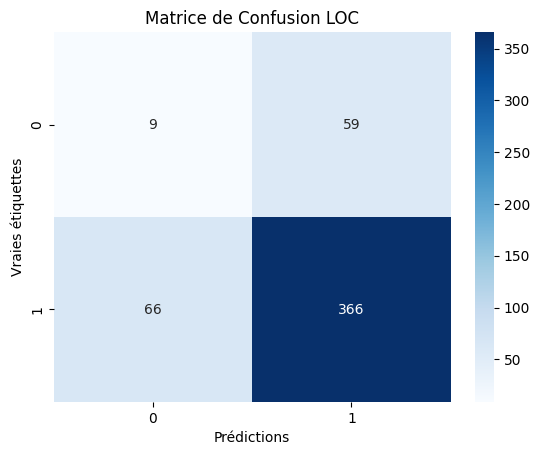

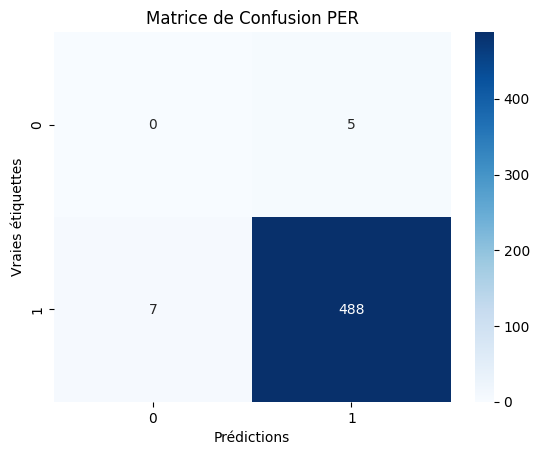

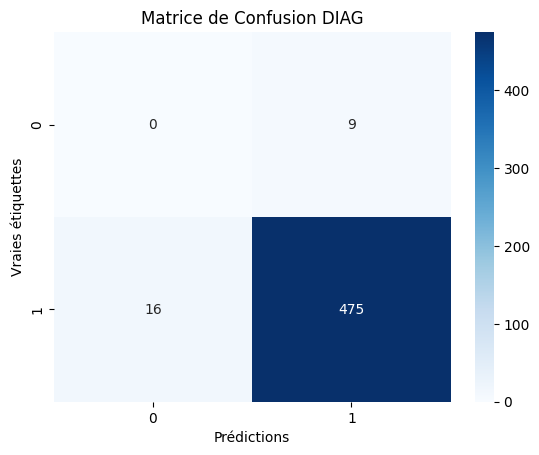

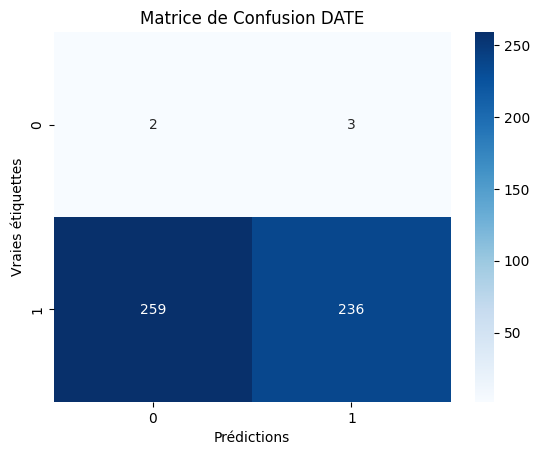

In [232]:
test = r'C:\PCO\generate_model\assets\dev.json'
with open(test, 'r', encoding='utf-8') as fichier:
    json_test = json.load(fichier)

confusion_matrix_generate(json_test, 'LOC')
confusion_matrix_generate(json_test, 'PER')
confusion_matrix_generate(json_test, 'DIAG')
confusion_matrix_generate(json_test, 'DATE')